In [15]:
# python library imports
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legfit, legval
import pandas as pd
import random
import pickle

# plot style commands
import modplot
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi']= 100

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve, roc_auc_score, auc

from util import get_model, signal_sweep, jetmass_hist, nn_output_hist, bagging_mlp, plot_auc_brf


In [7]:
# read in the R&D dataset from the LHC Olympics challenge
filename = '/Users/raymondwynne/Desktop/FORCE/data/LHCO/LHCO_'

# all of the constituents in the leading two jets of the event
#events = np.concatenate([np.load(filename + 'jets_{}.npz'.format(k))['arr_0'] for k in range(11)])

# the dijet masses and jet pTs of each of the events in the dataset
dijetmasses_in = np.load(filename+'dijetmasses.npz')['arr_0']
jetpts_in = np.load(filename+'jetpts.npz')['arr_0']

# the first thirteen energy flow polynomials for each jet, shape: (num_events, 2, num_efps)
efps_in = np.concatenate([np.load(filename+'efps_{}.npz'.format(k))['arr_0'] for k in range(11)])

# normalize the EFPs to dimensionless boost invariant ones
ns, ds =  np.asarray([1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 6]), np.asarray([0, 1, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3])
efpnorms_in = efps_in[:,:,0,np.newaxis]**(ns-2*ds) * efps_in[:,:,1,np.newaxis]**(ds)
efps_normed_in = np.nan_to_num(np.clip(efps_in/efpnorms_in, a_min=0, a_max=1000))

# labels as to whether the event was new physics or not. Used for validation only
labels_in = np.concatenate([np.load(filename+'labels{}.npz'.format(k))['arr_0'] for k in range(11)])

/var/folders/ms/4vjyd3l14sn5wrwm880cg3y40000gn/T/ipykernel_47028/946461701.py:17: RuntimeWarning: invalid value encountered in divide
  efps_normed_in = np.nan_to_num(np.clip(efps_in/efpnorms_in, a_min=0, a_max=1000))


In [8]:
# target number of signal events
background_subset = 100000
signal_subset = 100000

# keep all background events and the first "count" signal events
mask_background = np.zeros(len(labels_in), dtype=bool)
mask_signal = np.zeros(len(labels_in), dtype=bool)
mask_background[random.sample(list(np.where(labels_in==0)[0]), background_subset)] = True
mask_signal[random.sample(list(np.where(labels_in==1)[0]), 100000)] = True
        
# apply the filter and shuffle the data!
nev_background = np.count_nonzero(mask_background)
nev_signal = np.count_nonzero(mask_signal)

perm_background = np.random.permutation(nev_background)
perm_signal = np.random.permutation(nev_signal)

#events = events[mask][perm]
labels_background, dijetmasses_background = (labels_in[mask_background][perm_background], dijetmasses_in[mask_background][perm_background])
jetpts_background, jetpts_background_shuffle = (jetpts_in[mask_background][perm_background], jetpts_in[mask_background])
efps_background_shuffle, efps_normed_background_shuffle = (efps_in[mask_background], efps_normed_in[mask_background])
efps_background, efps_normed_background = (efps_in[mask_background][perm_background], efps_normed_in[mask_background][perm_background])

labels_signal, dijetmasses_signal = (labels_in[mask_signal][perm_signal], dijetmasses_in[mask_signal][perm_signal])
jetpts_signal, jetpts_signal_shuffle = (jetpts_in[mask_signal][perm_signal], jetpts_in[mask_signal])
efps_signal_shuffle, efps_normed_signal_shuffle = (efps_in[mask_signal], efps_normed_in[mask_signal])
efps_signal, efps_normed_signal = (efps_in[mask_signal][perm_signal], efps_normed_in[mask_signal][perm_signal])

perm_full = np.random.permutation(nev_background + nev_signal)

labels = np.concatenate([labels_background, labels_signal])[perm_full]
efps_normed = np.concatenate([efps_normed_background, efps_normed_signal])[perm_full]
efps_normed_shuffle = np.concatenate([efps_normed_background_shuffle, efps_normed_signal_shuffle])[perm_full]
efps = np.concatenate([efps_background, efps_signal])[perm_full]
jetpts = np.concatenate([jetpts_background, jetpts_signal])[perm_full]
jetpts_shuffle = np.concatenate([jetpts_background_shuffle, jetpts_signal_shuffle])[perm_full]
dijetmasses = np.concatenate([dijetmasses_background, dijetmasses_signal])[perm_full]


## Shuffled Features Models

In [20]:
with open('models_shuffle.pkl', 'rb') as f:
    models_shuffle = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-07-07 12:47:26         3269
metadata.json                                  2023-07-07 12:47:26           64
variables.h5                                   2023-07-07 12:47:26        42736
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
...vars
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-07-07 12:47:26         3269
metadata.json                                  2023-07-07 12:47:26  

In [21]:
labels_flatten = pd.DataFrame(np.concatenate([labels, labels]))


efp_filt = [2, 3, 4, 5, 6, 7, 8]
X = VarianceThreshold().fit_transform(np.concatenate((efps_normed[:,0,:], efps_normed[:,1,:]))[:,efp_filt])
y  = np.concatenate((jetpts_shuffle[:,0]/1000, jetpts_shuffle[:,1]/1000))

result_means = pd.DataFrame()

y_true = labels_flatten.values

for fs in sorted(list(models_shuffle.keys()), reverse=True):

    tprs = []
    log_tprs = []
    aucs = []
    fpr_grid = np.linspace(0, 1, 1000)
    fpr_log_grid = np.logspace(-4, 0, 1000)

    for model_list in models_shuffle[fs]:
        y_preds = np.mean([model_elem.predict(X, batch_size=100000, verbose=0)
                            for model_elem in model_list], axis=0)

        fpr, tpr, _ = roc_curve(y_true, y_preds)
        interp_tpr = np.interp(fpr_grid, fpr, tpr)
        interp_log_tpr = np.interp(fpr_log_grid, fpr, tpr)
        interp_tpr[0] = 0.0
        interp_log_tpr[0] = 0.0
        tprs.append(interp_tpr)
        log_tprs.append(interp_log_tpr)

        roc_auc = roc_auc_score(labels_flatten.values, y_preds)

        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    mean_log_tpr = np.mean(log_tprs, axis=0)
    log_tprs[-1] = 1.0

    std_tpr = np.std(tprs, axis=0)
    std_log_tpr = np.std(log_tprs)

    # mean_auc = auc(mean_fpr, mean_tpr)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    result_mean = pd.DataFrame(data=np.array([len(mean_tpr) * [fs], mean_tpr, mean_log_tpr, len(mean_tpr) * [mean_auc], len(mean_tpr) * [std_auc], std_tpr, std_log_tpr, fpr_grid, fpr_log_grid]).T,
                            columns=['fs', 'mean_tpr', 'mean_log_tpr', 'mean_auc', 'std_auc', 'std_tpr', 'std_log_tpr', 'fpr_grid', 'fpr_log_grid'])

    result_means = pd.concat([result_means, result_mean])

/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/numpy/core/_methods.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/numpy/core/_methods.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/numpy/core/_methods.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or 

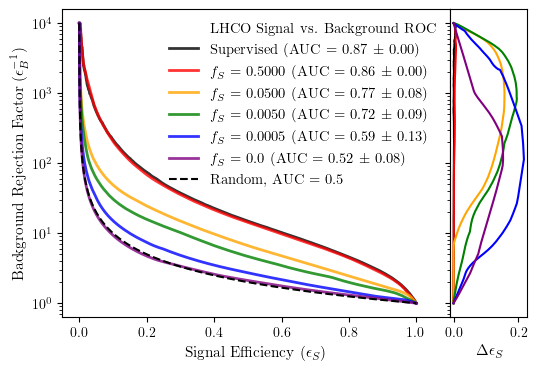

In [22]:
numeric = list(set(result_means.fs))
sorted_numeric = sorted(numeric, reverse=True)
sweep = ['Supervised'] + sorted_numeric

results = pd.concat([supervised, result_means])

# plot_auc_bs(results, sweep, '', '')
plot_auc_brf(results, sweep, title=None, save_as='auc_sweep')

In [9]:
with open('models.pkl', 'rb') as f:
    models = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-07-17 23:56:00         2830
metadata.json                                  2023-07-17 23:56:00           64
variables.h5                                   2023-07-17 23:56:00        37392
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
...vars
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-07-17 23:56:00         2830
metadata.json                                  2023-07-17 23:56:00           64
variables.h5                                   2023-07-17 23:56:00        37

In [16]:
labels_flatten = pd.DataFrame(np.concatenate([labels, labels]))


efp_filt = [2, 3, 4, 5, 6, 7, 8]
X = VarianceThreshold().fit_transform(np.concatenate((efps_normed[:,0,:], efps_normed[:,1,:]))[:,efp_filt])
y  = np.concatenate((jetpts[:,0]/1000, jetpts[:,1]/1000))

result_means = pd.DataFrame()

y_true = labels_flatten.values

for fs in sorted(list(models.keys()), reverse=True):

    tprs = []
    log_tprs = []
    aucs = []
    fpr_grid = np.linspace(0, 1, 1000)
    fpr_log_grid = np.logspace(-4, 0, 1000)

    for model_list in models[fs]:
        y_preds = np.mean([model_elem.predict(X, batch_size=100000, verbose=0)
                            for model_elem in model_list], axis=0)

        fpr, tpr, _ = roc_curve(y_true, y_preds)
        interp_tpr = np.interp(fpr_grid, fpr, tpr)
        interp_log_tpr = np.interp(fpr_log_grid, fpr, tpr)
        interp_tpr[0] = 0.0
        interp_log_tpr[0] = 0.0
        tprs.append(interp_tpr)
        log_tprs.append(interp_log_tpr)

        roc_auc = roc_auc_score(labels_flatten.values, y_preds)

        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    mean_log_tpr = np.mean(log_tprs, axis=0)
    log_tprs[-1] = 1.0

    std_tpr = np.std(tprs, axis=0)
    std_log_tpr = np.std(log_tprs)

    # mean_auc = auc(mean_fpr, mean_tpr)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    result_mean = pd.DataFrame(data=np.array([len(mean_tpr) * [fs], mean_tpr, mean_log_tpr, len(mean_tpr) * [mean_auc], len(mean_tpr) * [std_auc], std_tpr, std_log_tpr, fpr_grid, fpr_log_grid]).T,
                            columns=['fs', 'mean_tpr', 'mean_log_tpr', 'mean_auc', 'std_auc', 'std_tpr', 'std_log_tpr', 'fpr_grid', 'fpr_log_grid'])

    result_means = pd.concat([result_means, result_mean])

/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/numpy/core/_methods.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/numpy/core/_methods.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/Users/raymondwynne/opt/miniforge3/envs/tf/lib/python3.10/site-packages/numpy/core/_methods.py:198: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or 

In [17]:
supervised = pd.read_csv('/Users/raymondwynne/Desktop/FORCE/results/auc_sweep/fs_auc_supervised.csv')

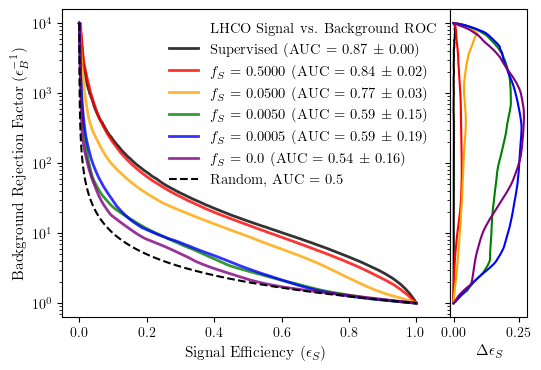

In [19]:
numeric = list(set(result_means.fs))
sorted_numeric = sorted(numeric, reverse=True)
sweep = ['Supervised'] + sorted_numeric

results = pd.concat([supervised, result_means])

# plot_auc_bs(results, sweep, '', '')
plot_auc_brf(results, sweep, title=None, save_as='auc_sweep')